# Airline Analysis

## TODO:
- get the distane of the edge based on longitude and latitude ✅
- add all the information to the graph so we have an easy time calculating the measures. ✅
- get list of graph theoretical measures to apply to airline networks:
    - number and strength of hubs 
    - network robustness measures
    - number of/ precense if paths
    - diameter of the graph
    - centrality measures
    - spectrum of graph
    - measure of correlation between country label
    - how much in country/out of country ✅
    - number of triangles in graph
    - set weights if we have multiple fights to same place by same airline ✅
    - get overlaping nodes functions. similarity of graph
- get planes associated with each flight in route, so we can get number of passagers. May do later only for the biggest airlines, at end of analysis ❓

Resources:

Economics:
http://www.oecd.org/daf/competition/airlinecompetition.htm

Graph theoretical:
https://beta.vu.nl/nl/Images/werkstuk-meer_tcm235-280356.pdf

aircraft traffic data by main airport:
https://datamarket.com/data/set/196g/aircraft-traffic-data-by-main-airport#!ds=196g!nto=6:ntp=b:ntq=3:ntr=1.1g.1u.7.z.a.j.v.1b.t.d.s.1n.12.p.8.b.y.e.19.17.1v.9.i.11.1f.1s.1a.1w.x.14.1l.1p.4.k.1r.g.1x.1c.f.15.q.1j.1t.l.1k.1h:nts=nf.rb&display=line





### Loading the dataset:

In [1]:
from  geopy.distance import distance #calculates distance based on coordinates

import operator
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!bash download_data.sh

Getting airports data
Getting airlines data
Getting routes data
Getting planes data


In [3]:
airports = pd.read_csv('airports.dat', header=None, names=
                      ["AirportID","Name", "City", "Country", "IATA", "ICAO",
                       "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabaseTimeZone",
                       "Type", "Source"],
                      na_values='\\N')
airlines = pd.read_csv('airlines.dat', header=None, names=
                       ["AirlineID", "Name", "Alias", "IATA", "ICAO", "Callsign", "Country", "Active"]
                       ,na_values='\\N')
routes = pd.read_csv('routes.dat', header=None, names=
                     ['Airline', 'AirlineID', 'SourceAirport', 'SourceAirportID', 'DestinationAirport',
                      'DestinationAirportID', 'Codeshare', 'Stops', 'Equipment'],
                    na_values='\\N')
planes = pd.read_csv('planes.dat', header=None, names=['Name', 'IATA code', 'ICAO code'])

Only keep airports in that are both in routes and airports dataframes:

In [4]:
valid_airports = set(airports.IATA).intersection(set(routes.SourceAirport).union(set(routes.DestinationAirport)))

In [5]:
routes = routes[routes.SourceAirport.isin(valid_airports) &  routes.DestinationAirport.isin(valid_airports)]
airports = airports[airports.IATA.isin(valid_airports)]

Only keep airlines in intersection of that are both in the airline and in the routes dataframe :

In [6]:
valid_airlines = set(airlines.AirlineID).intersection(set(routes.AirlineID))

In [7]:
airlines = airlines[airlines.AirlineID.isin(valid_airlines)]
routes = routes[routes.AirlineID.isin(valid_airlines)]

We check that for each airline we have exactly one edge between a given source and destination none. This means that our graph will be unweighted. 

In [8]:
routes_by_airline = routes[['SourceAirport', 'DestinationAirport', 'Airline']]
routes_by_airline.drop_duplicates().shape == routes_by_airline.shape

True

### Merging Routes with Airlines:

We are only interessted in currently active airlines:

In [9]:
merged_routes = pd.merge(airlines[airlines.Active == 'Y'], routes, on='AirlineID')

In [10]:
merged_routes.head(1)

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment
0,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,MRS,1353.0,NaN,0,319


Getting whether the flight is international or not:

In [11]:
Airport_to_country = airports.set_index('IATA').Country.to_dict()

In [12]:
merged_routes['International'] = merged_routes.apply(
    lambda x: 1 if Airport_to_country[x.SourceAirport] == Airport_to_country[x.DestinationAirport] else 0, axis=1)

reset frames to create mappings:

In [13]:
#only keep values we are interested in
airports_filtered = airports[['Name', 'Country', 'Longitude', 'Latitude', 'Timezone', 'IATA', 'City']].copy()

In [14]:
#IATA airport id -> longitude latitude
#airports_filtered.dropna(inplace=True)
airports_filtered.set_index('IATA', inplace=True)

airports_filtered.Longitude.dropna().shape == airports_filtered.Longitude.shape


True

In [15]:
print(airports.Longitude.shape)
print(airports_filtered.Longitude.shape)

(3221,)
(3221,)


In [16]:
location_mapping = airports_filtered.apply(lambda x: [x.Longitude, x.Latitude], axis=1).to_dict()

In [17]:
#Airline name -> airlineID
airline_name_to_number = merged_routes.Name.drop_duplicates().reset_index(drop=True).to_dict()
airline_name_to_number = {v: k for k, v in airline_name_to_number.items()}

In [18]:
merged_routes['AirlineNbr'] = merged_routes.Name.map(airline_name_to_number)

Fill in Nan values:

In [19]:
merged_routes['Codeshare'] = merged_routes.Codeshare.fillna('N')

### Getting the distance between two airports:

Example of functionality:

In [20]:
element = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[0]
element2 = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[1]

In [21]:
distance(element, element2).km

106.2489585209369

In [22]:
distance_mapping = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1).to_dict()

Additing it to merged_routes:

In [23]:
merged_routes['Distance'] = merged_routes.apply(lambda x: 
                distance(distance_mapping[x.SourceAirport], distance_mapping[x.DestinationAirport]).km, axis=1)

In [24]:
relevant_columns = ['Name', 'ICAO', 'Country', 'SourceAirport', 'DestinationAirport', 'Codeshare',
                    'Stops', 'Equipment', 'AirlineNbr', 'International', 'Distance']

In [25]:
merged_routes.head()

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,International,AirlineNbr,Distance
0,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,MRS,1353.0,N,0,319,0,0,767.018752
1,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,ORY,1386.0,N,0,319,0,0,1393.826859
2,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,CDG,1382.0,N,0,319,0,0,1369.896021
3,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,LIL,1399.0,N,0,320,0,0,1541.323265
4,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,LYS,1335.0,N,0,320 319,0,0,1015.406743


In [26]:
merged_routes[relevant_columns].head()

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance
0,Aigle Azur,AAF,France,AAE,MRS,N,0,319,0,0,767.018752
1,Aigle Azur,AAF,France,AAE,ORY,N,0,319,0,0,1393.826859
2,Aigle Azur,AAF,France,ALG,CDG,N,0,319,0,0,1369.896021
3,Aigle Azur,AAF,France,ALG,LIL,N,0,320,0,0,1541.323265
4,Aigle Azur,AAF,France,ALG,LYS,N,0,320 319,0,0,1015.406743


In [27]:
merged_routes = merged_routes[relevant_columns]

## Preliminary analysis of the biggest airlines:

In [28]:
merged_routes.Name.value_counts().head(10)

Ryanair                    2482
American Airlines          2340
United Airlines            2172
Delta Air Lines            1977
US Airways                 1947
China Southern Airlines    1420
Air China                  1238
China Eastern Airlines     1215
Southwest Airlines         1140
easyJet                    1130
Name: Name, dtype: int64

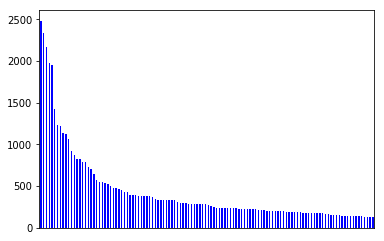

In [29]:
merged_routes.Name.value_counts().head(120).plot(kind='bar', color='b')
_ = plt.xticks([])

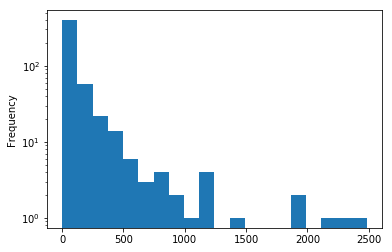

In [30]:
merged_routes.Name.value_counts().plot(kind='hist', log=True, bins=20)

In [31]:
merged_routes.Name.value_counts().describe()

count     517.000000
mean      125.947776
std       276.469028
min         1.000000
25%        14.000000
50%        34.000000
75%       111.000000
max      2482.000000
Name: Name, dtype: float64

In [32]:
reasonably_big_airlines = merged_routes.Name.value_counts()[merged_routes.Name.value_counts() > 50].index

In [33]:
merged_routes = merged_routes[merged_routes.Name.isin(reasonably_big_airlines)]

We look at a total of 212 airlines:

In [34]:
merged_routes.Name.unique().shape

(211,)

### Meta-Data analysis

Propotion of international to national flights

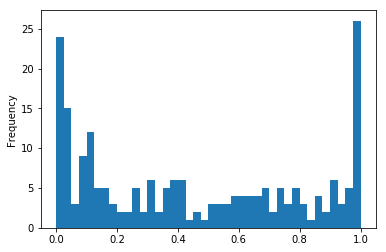

In [35]:
merged_routes.groupby('Name').International.mean().plot(kind='hist', bins=40)

mean distance of flights:

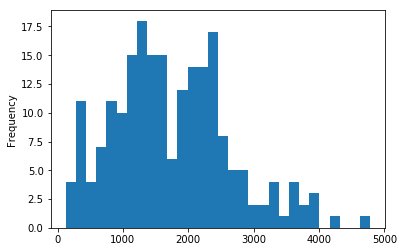

In [36]:
merged_routes.groupby('Name').Distance.mean().plot(kind='hist', bins=30)

Max distance of flights:

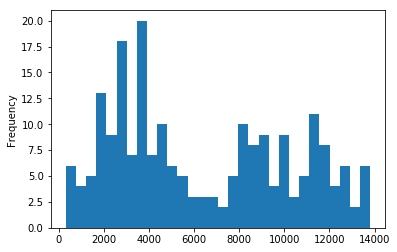

In [37]:
merged_routes.groupby('Name').Distance.max().plot(kind='hist', bins=30)

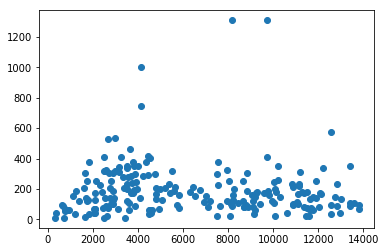

In [38]:
plt.scatter(merged_routes.groupby('Name').Distance.max(),  merged_routes.groupby('Name').Distance.min())

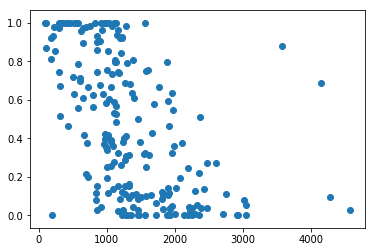

In [39]:
plt.scatter(merged_routes.groupby('Name').Distance.median(),  merged_routes.groupby('Name').International.mean())

shortest distance of flight:

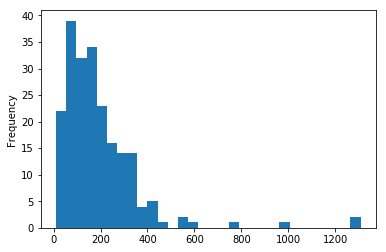

In [40]:
merged_routes.groupby('Name').Distance.min().plot(kind='hist', bins=30)

Proportion of codeshare flights:

In [41]:
merged_routes['Codeshare'] = merged_routes.Codeshare.map(lambda x: 1 if x == 'Y' else 0)

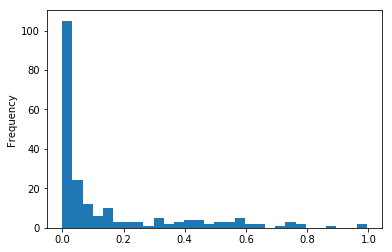

In [42]:
merged_routes.groupby('Name').Codeshare.mean().plot(kind='hist', bins=30)

## Create graph of all airlines:

Create graph with edge having airline associated to

In [ ]:
biggest = merged_routes.AirlineNbr.value_counts().head(10).index

In [ ]:
edge_attributes = ['Country', 'Name', 'AirlineNbr', 'Distance', 'International']

In [ ]:
Airline_Graph = nx.from_pandas_edgelist(merged_routes[merged_routes.AirlineNbr.isin(biggest)], 
                                        source='SourceAirport', 
                                        target='DestinationAirport', 
                                        edge_attr=['Country', 'Name', 'AirlineNbr', 'Distance', 'International'])

In [ ]:
color_edges = list(nx.get_edge_attributes(Airline_Graph, 'AirlineNbr').values())

In [ ]:
nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')

In [ ]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(Airline_Graph, 
                 pos=nx.get_node_attributes(Airline_Graph, 'Location'), 
                 edge_color=color_edges, edge_cmap=plt.cm.Set2, node_size=0, labels=dict(), alpha=0.4)

Example analysis of one graph:

In [ ]:
def create_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])
    nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')
    return Airline_Graph

In [ ]:
Ryanair = create_airline_network('Ryanair')

In [ ]:
e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Ryanair).todense())

In [ ]:
plt.plot(e)

In [ ]:
Lufthansa = create_airline_network('Lufthansa')

In [ ]:
e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Lufthansa).todense())
plt.plot(e)

In [ ]:
nx.node_connectivity(Ryanair)

In [ ]:
plt.boxplot(nx.degree_centrality(Ryanair).values())

In [ ]:
nx.average_clustering(Ryanair)

In [ ]:
nx.k_nearest_neighbors(Ryanair)

In [ ]:
nx.triangles(Ryanair)

In [ ]:
nx.diameter(Ryanair)

In [ ]:
nx.estrada_index(Ryanair)

In [ ]:
nx.eccentricity(Ryanair)

In [ ]:
merged_routes.Name.value_counts().plot(kind='box')

In [ ]:
merged_routes.Name.value_counts().describe()

In [ ]:
merged_routes.Name.value_counts()[merged_routes.Name.value_counts() > 100]

In [ ]:
merged_routes.Country.value_counts().head(20)

In [ ]:
merged_routes.Codeshare.value_counts()

In [ ]:
Low_cost = ['Southwest Airlines', 'Virgin America', 'AirAsia', 'Ryanair','easyJet', 'WestJet', 'Pegasus Airlines', 'Spirit Airlines', 'Mango']

In [ ]:
merged_routes[merged_routes.Name.isin(Low_cost)].Name.value_counts()

In [ ]:
merged_routes.head()

In [ ]:
def draw_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])

    plt.figure(figsize=(10, 10))
    centrality = nx.betweenness_centrality(Airline_Graph)
    size = np.array(list(centrality.values()))*1000
    nx.draw_spring(Airline_Graph, node_size=size, width=0.1)
    plt.title(airline)
    plt.show()
    e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Airline_Graph).todense())
    plt.plot(e)
    plt.show()
    plt.plot(nx.laplacian_spectrum(Airline_Graph))
    plt.show()
    plt.boxplot(nx.degree_centrality(Airline_Graph).values())
    plt.show()
    

In [ ]:
for cheap in Low_cost:
    draw_airline_network(cheap)

In [ ]:
Best_Airlines = ['Singapore Airlines', 'Emirates', 'Lufthansa', 'Qatar Airways', 'Cathay Pacific']

In [ ]:
for best in Best_Airlines:
    draw_airline_network(best)

In [ ]:
Large_Airlines = ['Delta Air Lines', 'Air France', 'China Southern Airlines', 'Turkish Airlines', 'American Airlines']

In [ ]:
for best in Large_Airlines:
    draw_airline_network(best)

In [ ]:
merged_routes.Name.unique()

In [ ]:
Chinese = ['China Southern Airlines', 'China Eastern Airlines', 'Air China']

In [ ]:
for best in Chinese:
    draw_airline_network(best)

## Adding in external information: for relected airlines - case study

In [ ]:
Delays_data = pd.read_csv('🏬 AIRLINE LIST  ✈️  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - Delays data (raw).csv')

In [ ]:
Airline_list = pd.read_csv('🏬 AIRLINE LIST  ✈️  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - 🏬 Airlines.csv')

In [ ]:
set(Airline_list.name.map(lambda x: x.lower())).intersection(set(merged_routes.Name.map(lambda x: x.lower())))

In [ ]:
merged_routes.Name.head()

In [ ]:
set(Delays_data['On-time'].map(lambda x: x.lower())).intersection(set(merged_routes.Name.map(lambda x: x.lower())))

# Networks Analysis

In [ ]:
def airlines_network_analysis(airline):
    
    Airline_Graph = create_airline_network(airline)
    
    #Highlights hubs   
    print("10% biggest airports of ", airline)
    print()
    deg = np.array(list(Airline_Graph.degree))
    deg_value = deg[:,1]
    deg_value = deg_value.astype(np.float)
    plt.hist(deg_value, bins=50, )
    perc = np.percentile(deg_value, q=90)
    biggest_hubs = np.array(np.where(deg_value > perc))

    for i in np.nditer(biggest_hubs):
        print(airports[airports.IATA == deg[i,0]].Name.to_string(index=False), "has degree : ", deg[i,1])
    
    
    #Diameter,robustness
    print("Anlysis")
    print("Number of edges : ", Airline_Graph.number_of_edges())
    print("Number of nodes", Airline_Graph.number_of_nodes(), "nodes")
    print("Diameter : ", nx.diameter(Airline_Graph))
    print("Node connectivity", nx.node_connectivity(Airline_Graph))
    
    eb = nx.edge_betweenness_centrality(Airline_Graph)
    key, value = max(eb.items(), key = lambda p: p[1])
    print("Max edge betwenness: ",value , "from ", airports[airports.IATA == key[0]].Name.to_string(index=False), "to", airports[airports.IATA == key[1]].Name.to_string(index=False))
    key, value = min(eb.items(), key = lambda p: p[1])
    print("Min edge betwenness: ",value, "from", airports[airports.IATA == key[0]].Name.to_string(index=False), "to", airports[airports.IATA == key[1]].Name.to_string(index=False))
                                                            
    nb = nx.betweenness_centrality(Airline_Graph)
    key, value = max(nb.items(), key= lambda p:p[1])
    print("Max node betwenness: ", value, "airport",airports[airports.IATA == key].Name.to_string(index=False))
    key, value = min(nb.items(), key= lambda p:p[1])
    print("Min node betwenness: ", value, "airport",airports[airports.IATA == key].Name.to_string(index=False))
    print("Algbraic connectivity: ", nx.algebraic_connectivity(Airline_Graph))
    
    #Plot network
    draw_airline_network(airline)
    

In [ ]:
airlines_network_analysis('Ryanair')

In [ ]:
airlines_network_analysis('Turkish Airlines')

## Competition Analysis

In [47]:
merged_routes['SourceCountry'] = merged_routes.apply(lambda x: 
                Airport_to_country[x.SourceAirport], axis=1)
merged_routes['DestinationCountry'] = merged_routes.apply(lambda x: 
                Airport_to_country[x.DestinationAirport], axis=1)
merged_routes.head(5)

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance,SourceCountry,DestinationCountry
0,Aigle Azur,AAF,France,AAE,MRS,0,0,319,0,0,767.018752,Algeria,France
1,Aigle Azur,AAF,France,AAE,ORY,0,0,319,0,0,1393.826859,Algeria,France
2,Aigle Azur,AAF,France,ALG,CDG,0,0,319,0,0,1369.896021,Algeria,France
3,Aigle Azur,AAF,France,ALG,LIL,0,0,320,0,0,1541.323265,Algeria,France
4,Aigle Azur,AAF,France,ALG,LYS,0,0,320 319,0,0,1015.406743,Algeria,France


In [54]:
display(merged_routes[merged_routes['SourceCountry'].isna()])
display(merged_routes[merged_routes['DestinationCountry'].isna()])

display(merged_routes[merged_routes['SourceAirport'].isna()])
display(merged_routes[merged_routes['DestinationAirport'].isna()])

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance,SourceCountry,DestinationCountry


,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance,SourceCountry,DestinationCountry


,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance,SourceCountry,DestinationCountry


,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance,SourceCountry,DestinationCountry


In [ ]:
def overlaps(route_a, route_b):
    source_dist = distance(distance_mapping[route_a['SourceAirport']],
                           distance_mapping[route_b['SourceAirport']]).km
    dest_dist = distance(distance_mapping[route_a['DestinationAirport']],
                         distance_mapping[route_b['DestinationAirport']]).km
    return source_dist <= 100 and dest_dist <= 100

"""
Computed the overlap (competition) score between two airlines.
It takes not only nodes into consideration but also the edges.
So, if Airline A goes from Bucharest to Zurich and Airline B
from Geneva to Zurich, based on this fact only, they are not
competitors.
"""
def compute_overlap_score(airline_x, airline_y):
    routes_x = merged_routes[merged_routes.Name == airline_x]
    routes_y = merged_routes[merged_routes.Name == airline_y]
    
    score = 0
    for i, row_x in routes_x.iterrows():
        does_overlap = False
        joined_routes = routes_y[(routes_y.SourceCountry == row_x['SourceCountry']) &
                                 (routes_y.DestinationCountry == row_x['DestinationCountry'])]
        for j, row_y in joined_routes.iterrows():
            if overlaps(row_x, row_y):
                does_overlap = True
        if does_overlap:
            score += 1
    return score / len(routes_x)

compute_overlap_score("Ryanair", "Wizz Air")

In [ ]:
"""
Computed the overlap (competition) score between given airlines.
It takes not only nodes into consideration but also the edges.
So, if Airline A goes from Bucharest to Zurich and Airline B
from Geneva to Zurich, based on this fact only, they are not
competitors.
"""
def compute_overlap_scores(airline_list):
    scores = []
    for airline_a in airline_list:
        for airline_b in airline_list:
            scores.append([airline_a, airline_b, compute_overlap_score(airline_a, airline_b)])
    return pd.DataFrame(scores, columns = ['AirlineA', 'AirlineB', 'Score'])

In [ ]:
overlap_scores = compute_overlap_scores(["Ryanair", "Wizz Air"])
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(Low_cost)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(Best_Airlines)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(Large_Airlines)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(Chinese)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(airlines.Name)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [46]:
merged_routes

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance
0,Aigle Azur,AAF,France,AAE,MRS,0,0,319,0,0,767.018752
1,Aigle Azur,AAF,France,AAE,ORY,0,0,319,0,0,1393.826859
2,Aigle Azur,AAF,France,ALG,CDG,0,0,319,0,0,1369.896021
3,Aigle Azur,AAF,France,ALG,LIL,0,0,320,0,0,1541.323265
4,Aigle Azur,AAF,France,ALG,LYS,0,0,320 319,0,0,1015.406743
5,Aigle Azur,AAF,France,ALG,MRS,0,0,319,0,0,768.527296
6,Aigle Azur,AAF,France,ALG,ORY,0,0,320 319,0,0,1338.370829
7,Aigle Azur,AAF,France,ALG,TLS,0,0,320 319,0,0,786.314943
8,Aigle Azur,AAF,France,BJA,MRS,0,0,320,0,0,747.082675
9,Aigle Azur,AAF,France,BJA,ORY,0,0,320 319,0,0,1352.151328
